# Autonomous Driving : Car Detection
- We'll implement object detection using the very powerful YOLO model.
- We'll be able to :
    - Detect objects in a car detection dataset
    - Implement non-max supression to increase accuracy
    - Implement intersection over union
    - Handle bounding boxes, a type of image annotation popular in deep learning.

# Packages

In [17]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras import backend as K

from tensorflow.keras.models import load_model

# 1. Problem Statement
- We are working on a self-driving car. We'd like to first build a car detection system. To collect data, we've mounted a camera to the hood of the car, which takes pictures of the road ahead every few seconds as we drive around.
- We've gathered all these images into a folder and labelled them by drawing bounding boxes around every car we found. 
    - 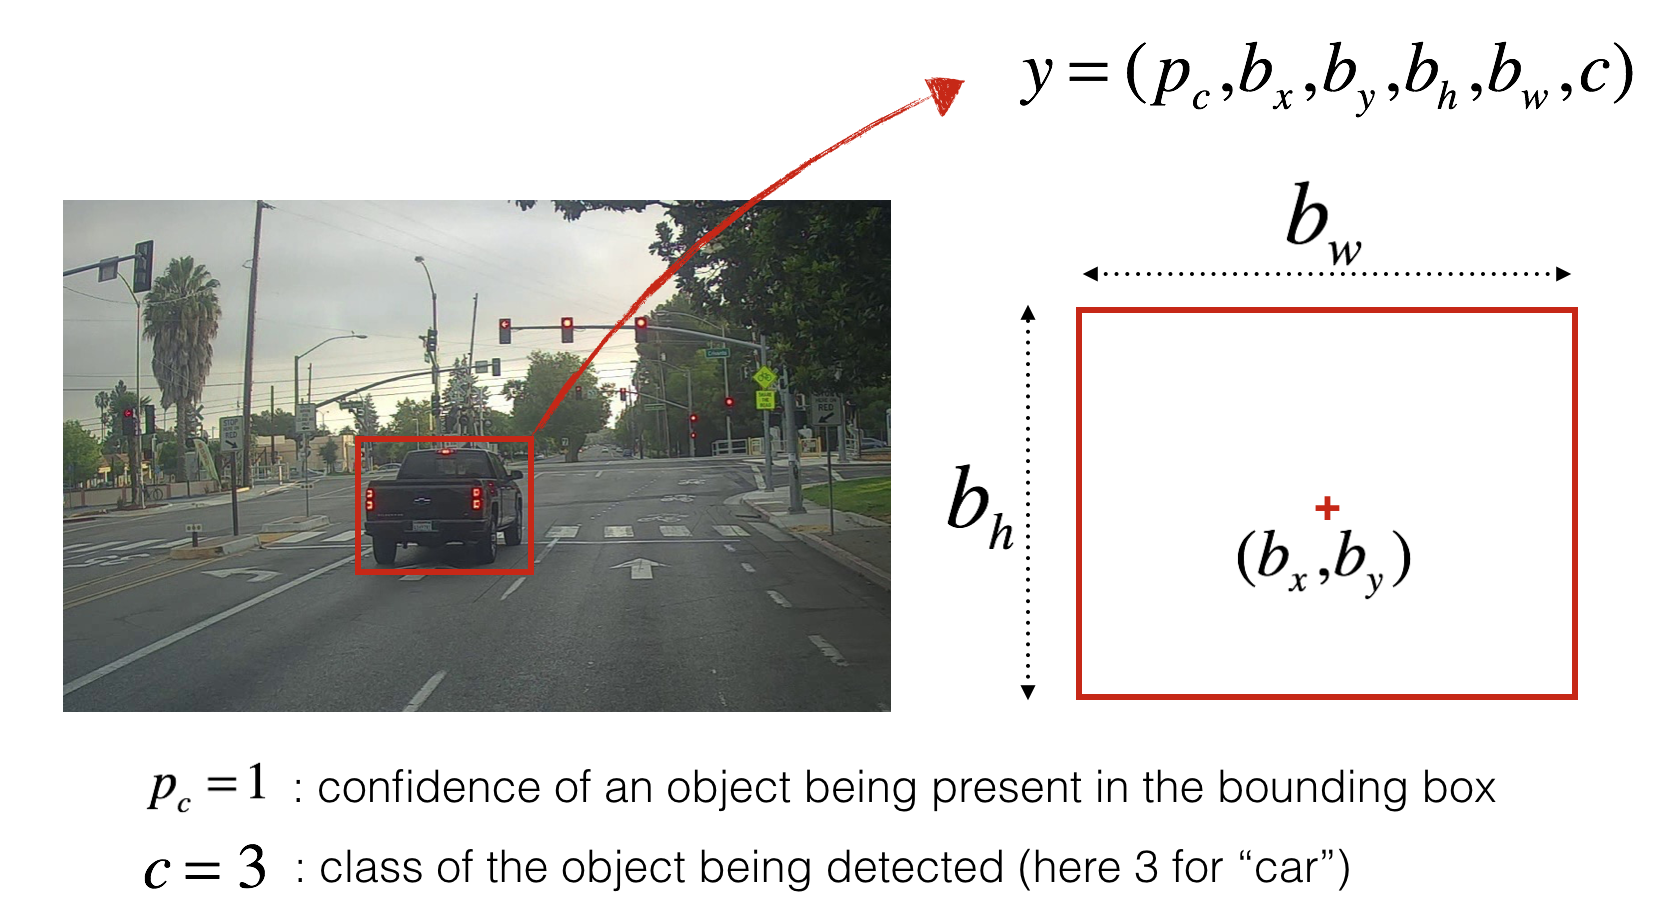
- pc = 1 : Confidence of an object being present in the bounding box; c = 3 : Class of the object being detected (3 for 'car')
- If there are 80 classes we want the object detector to recognize, we can represent the class label c either as an integer from 1 to 80 or as an 80-dimensional vector (with 80 numbers) one component of which is 1, and the rest of which are 0.
- We'll discover how YOLO (You Only Look Once) performs object detection, and then apply it to car detection. Because the YOLO model is very computationally expensive to train, the pre-trained weights are already loaded for us to use.

# 2. YOLO
- 'You Only Look Once' is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm 'Only Looks Once' at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max supression, it then outputs recognized objects together with the bounding boxes.

## 2.1 Model Details
### Inputs & Outputs
- The input is a batch of images and each image has the shape (608, 608, 3).
- The output is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers (pc, bx, by, bh, bw, c). If we expand c into an 80-dimenional vector, each bounding box is then represented by 85 numbers.

### Anchor Boxes
- Anchor boxes are chosen by exploring the training data to choose reasonable heigh/width ratios that represent the different classes. 
- The dimension of the encoding tensor of the 2nd to last dimension based on the anchor box is 
    - (m, nh, nw, anchors, classes)
 - The YOLO architecture is IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).
 
### Encoding :
- 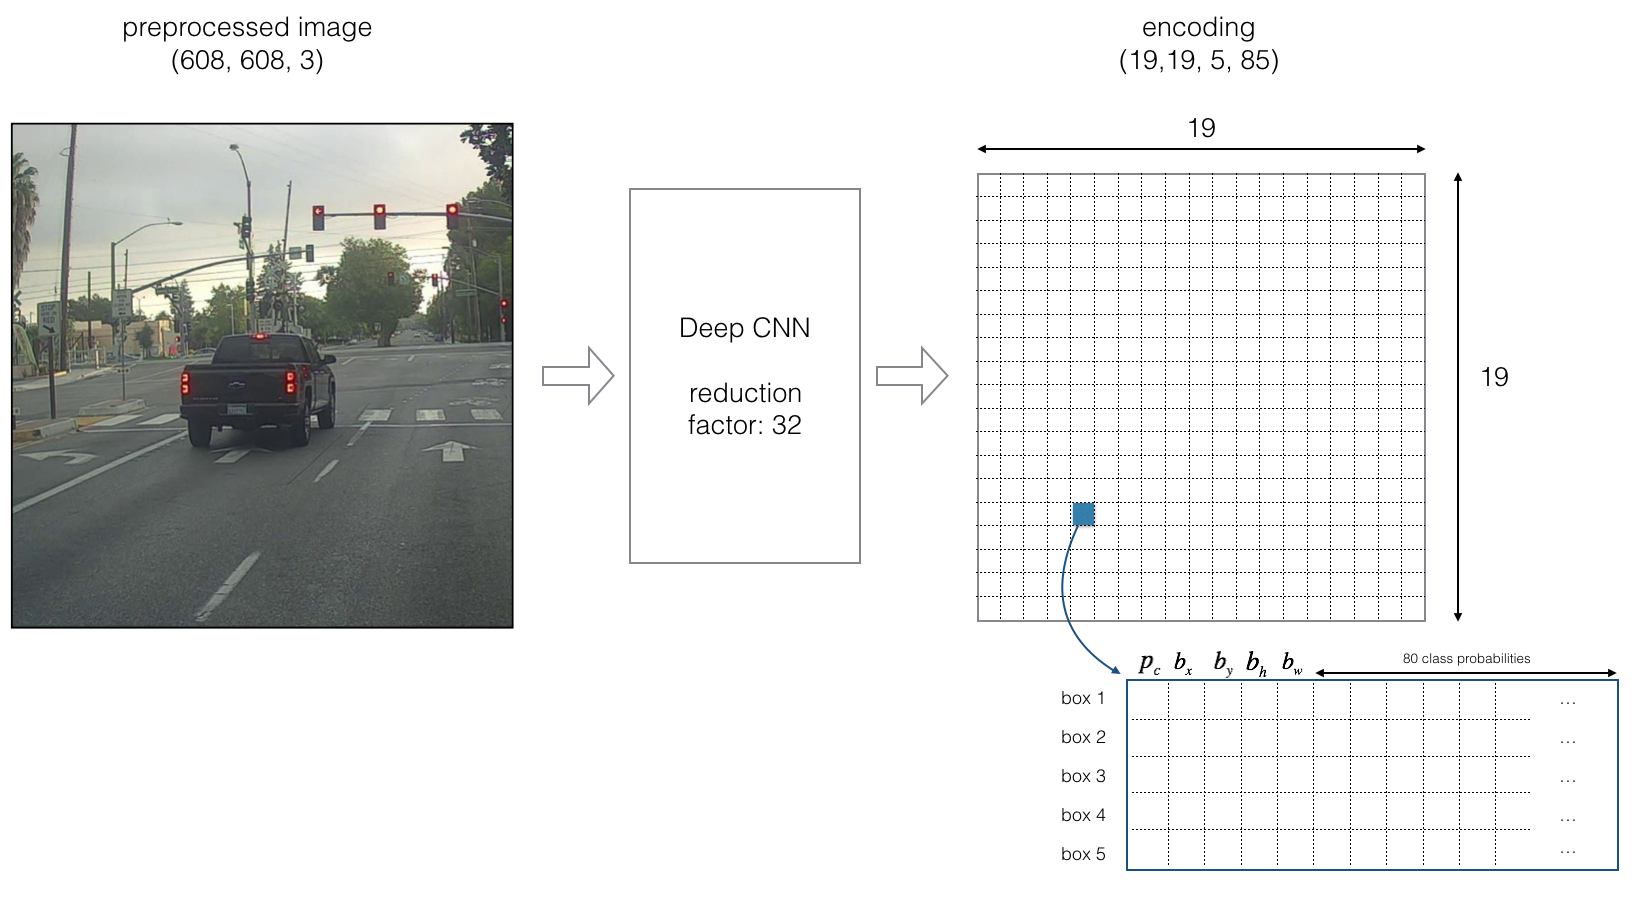
- If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.
- Since, we're using 5 anchor boxes, each of the 19x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.
- For simplicity, we'll flatten the last 2 dimensions of the shape (19, 19, 5, 85) encoding, so the ouput of the Deep CNN is (19, 19, 425)
- 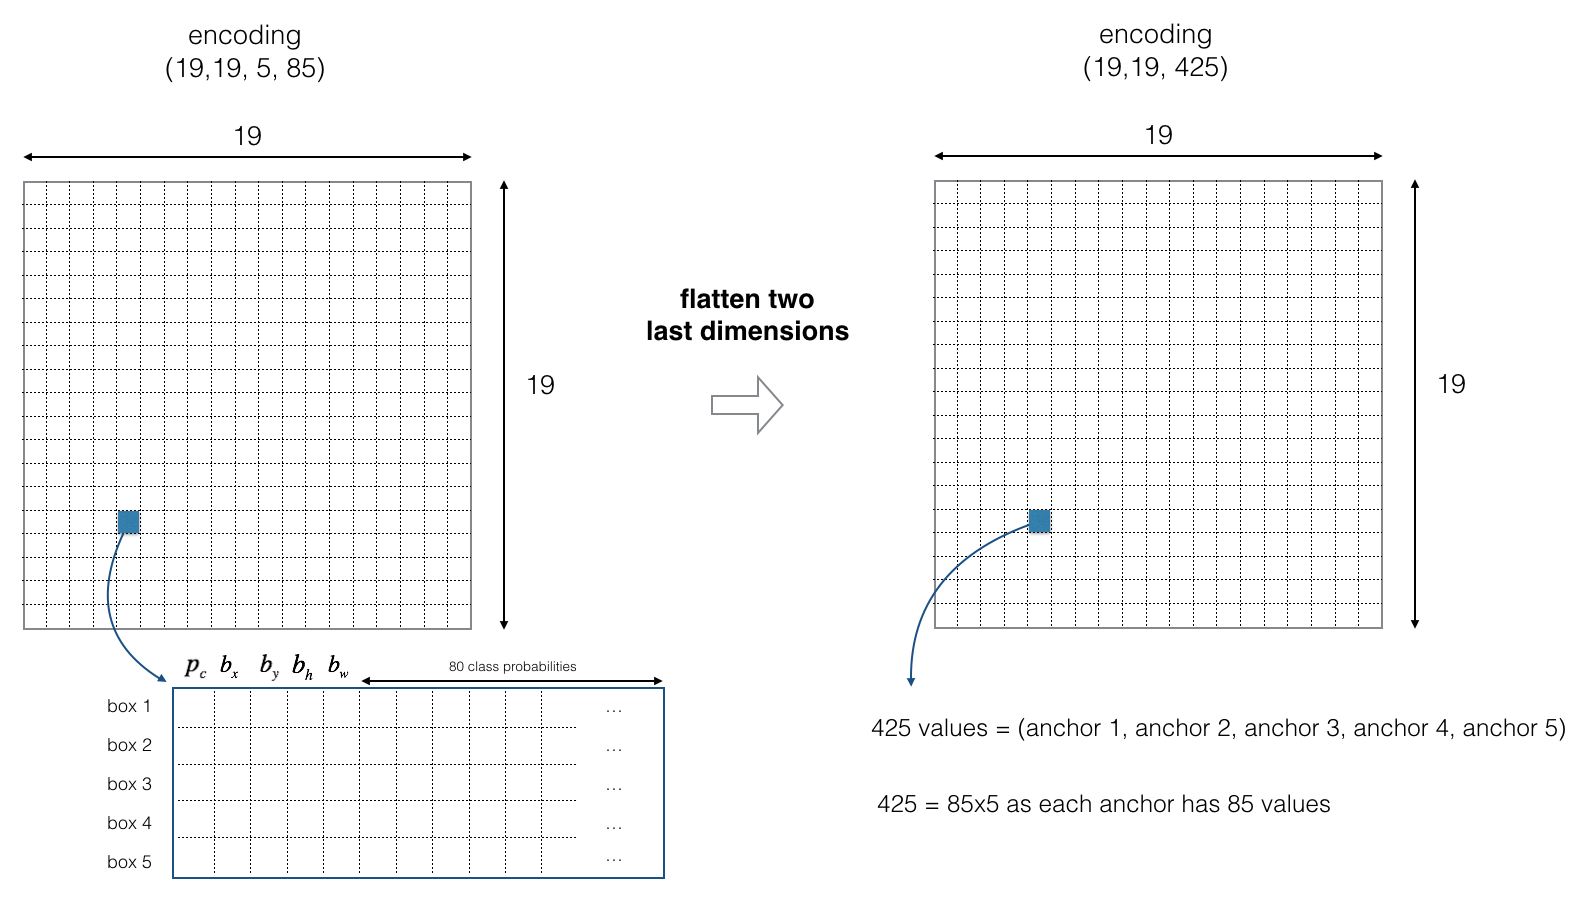

### Class Score
- Now, for each box (of each cell) we'll compute the following element-wise product and extract a probability that the box contains a certain class.
- The class score is score_c,i = p_c*c_i : The probability that there is an object p_c times the probability that the object is a certain class c_i.
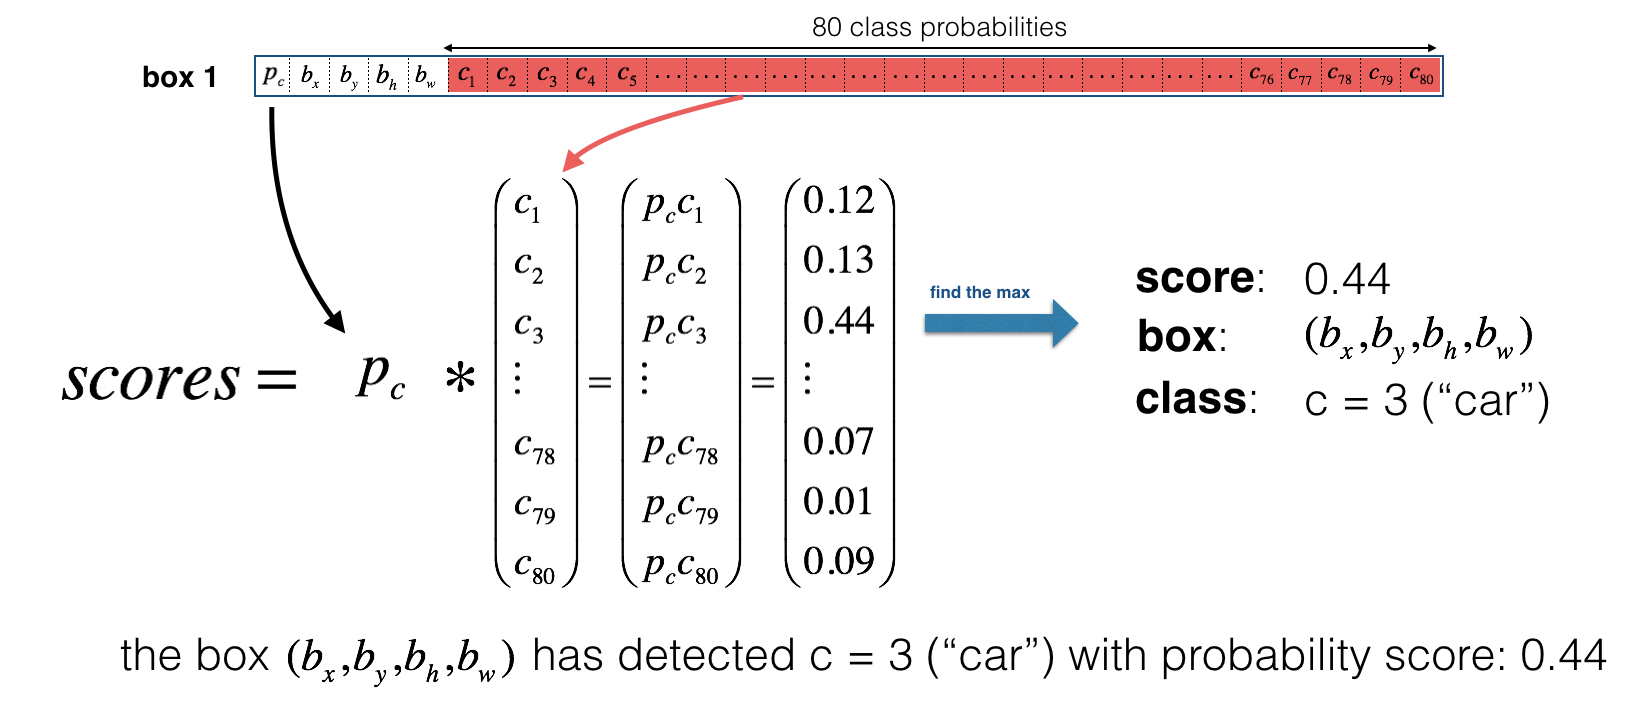
- Example :
    - In the figure, let's say for box 1 (cell 1), the probability that an object exists is p_1 = 0.60. So there's a 60% chance that an object exists in cell 1.
    - The probability that the object is the class 'category 3 (a car)' is c_3 = 0.73
    - The score for box 1 and for category '3' is score_1,3 = 0.60*0.73 = 0.44
    - Say we calculate the score for all 80 classes in box 1, and find the score for the car class (class 3) is the maximum. So we'll assign the score 0.44 and class '3' to the box '1'.
    
### Visualizing Classes
- Here's one way to visualize what YOLO is predicting on an image:
    - For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes)
    - Color that grid cell according to what object that grid cell considers the most likely.
- 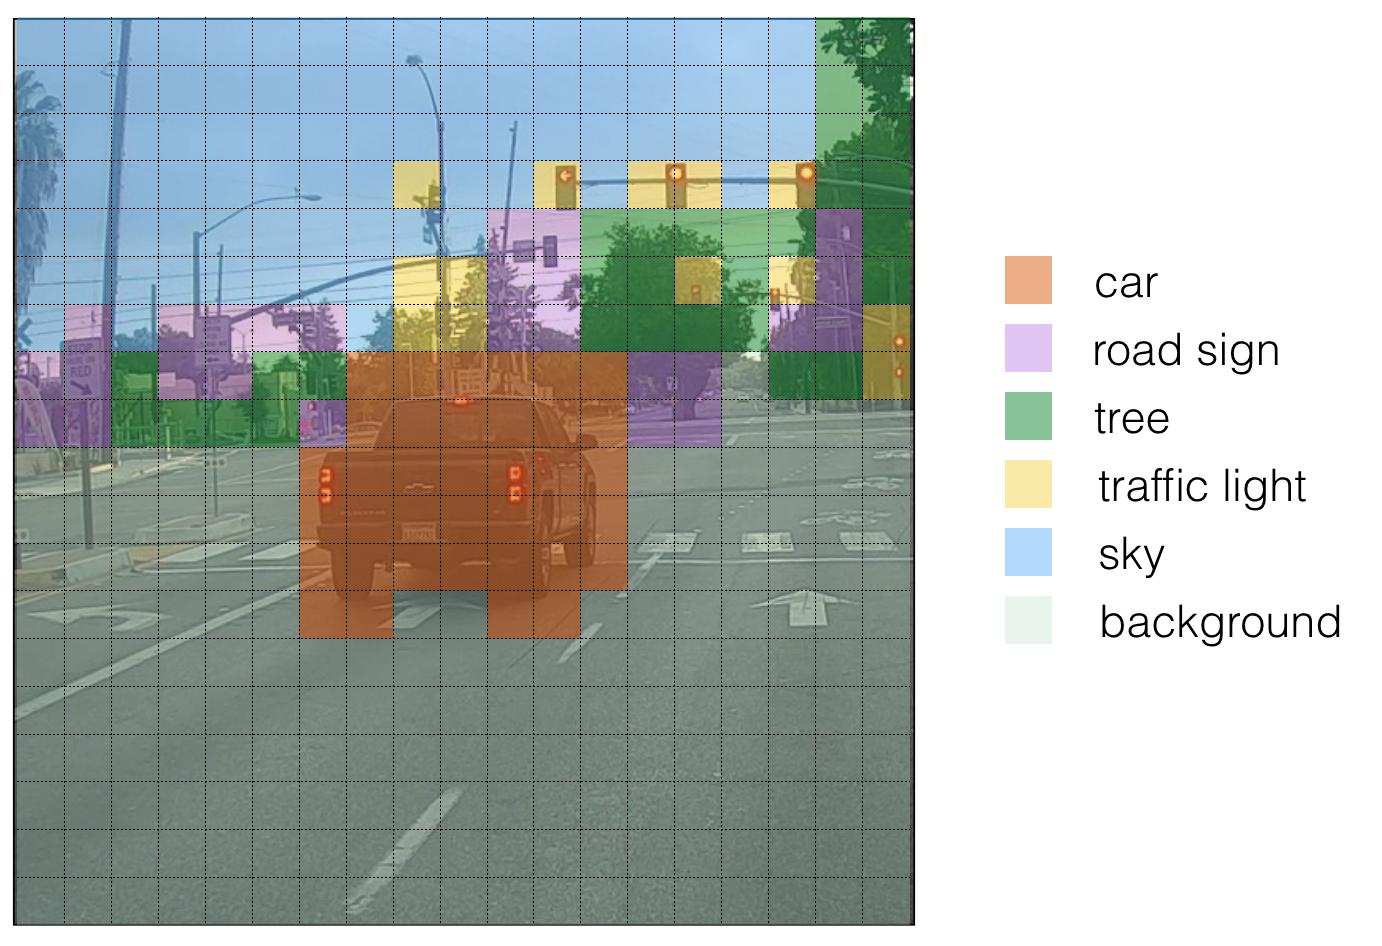
- Note that this visualizing isn't a core part of the YOLO algorithm itself for making predictions, it's just a nice way of visualizing an intermediate result of the algorithm.

### Visualizing bounding boxes
- Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualzation like :
    - 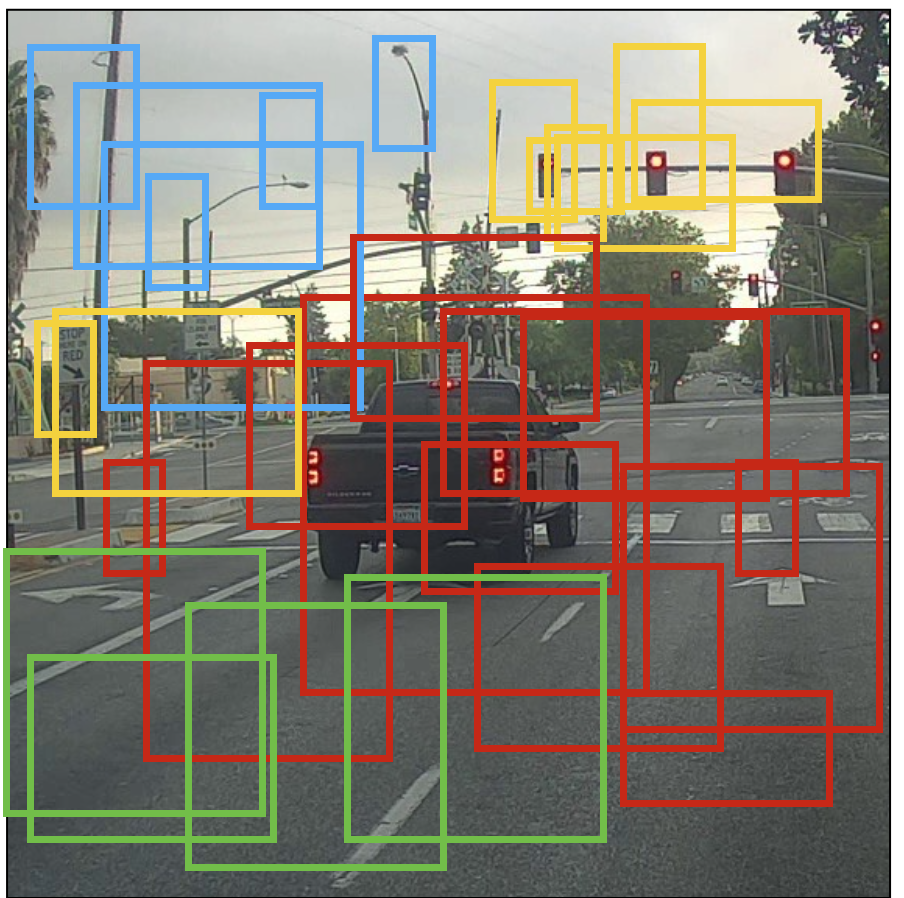

### Non-Max Suppression
- The only boxes plotted are ones for which the model has assigned the high probability, but this is still to many boxes. We'd like to reduce the algorithm's output to a much smaller number of detected objects.
- To do so, we'll use non-max supression. Specifically, we'll carry out these steps :
    - Get rid of boxes with a low score. Meaning, the box is not very confident about a class, either due to the low probability of any object, or low probability of this particular class.
    - Select only one box when several boxes overlap with each other and detect the same object.
    
   
## 2.2 Filtering with a Threshold on class scores
- We're going to first apply a filter by threshold, meaning we'll get rid of any box for which the class 'score' is less than a chosen threshold.
- The model gives us a total of 19x19x5x85 numbers, with each box described by 85 numbers. It's convenient to rearrange the (19, 19, 5, 85) or (19, 19, 425) dimensional tensor into the following variables :
    - box_confidence : tensor of shape (19, 19, 5, 1) containing p_c (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
    - boxes : Tensor of shape (19, 19, 5, 4) containing the midpoint and dimensions (b_x, b_y, b_h, b_w) for each of the 5 boxes in each cell.
    - box_class_probs : Tensor of shape (19, 19, 5, 80) containing the class probabiliies (c1, c2, ...c80) for each of the 80 classes for each of the 5 boxes per cell.

### yolo_filter_boxes
1. Compute box scores by doing the elementwise products as 
    - a = np.random.randn(19, 19, 5, 1)
    - b = np.random.randn(19, 19, 5, 80)
    - c = a * b # shape of c will be (19, 19, 5, 80)
2. For each box, find
    - The index of the class with maximum box score
    - The corresponding box score
3. Create a mask by using a threshold. ([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4) returns : [False, True, False, False, True]. The mask should be True for the boxes we want to keep.
4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. We should be left with just the subset of boxes we want to keep.

In [4]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    # IMPORTANT: set axis to -1
    box_classes = tf.math.argmax(box_scores, axis = -1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask) 
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    return scores, boxes, classes

In [5]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)


## 2.3 Non-max suppression
- Even after filtering by thresholding over the class scores, we will still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-max supression (NMS)
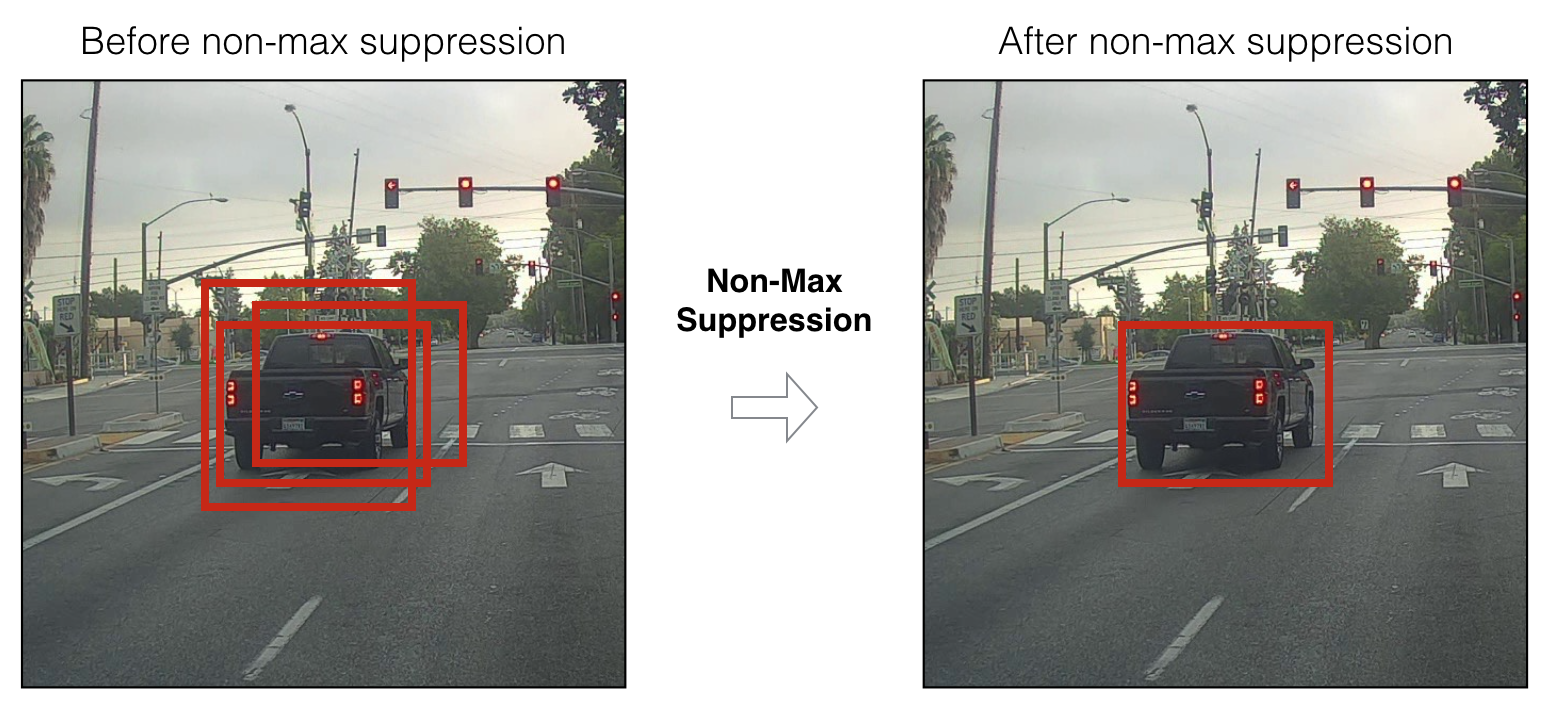
- In this example, the model has predicted 3 cars but it's actually 3 predictions of the same car. Running non-max supression (NMS) will select only the most accurate (highest probability) of the 3 boxes.
- Non-max suppression uses the very important function called 'Intersection over Union'
    - 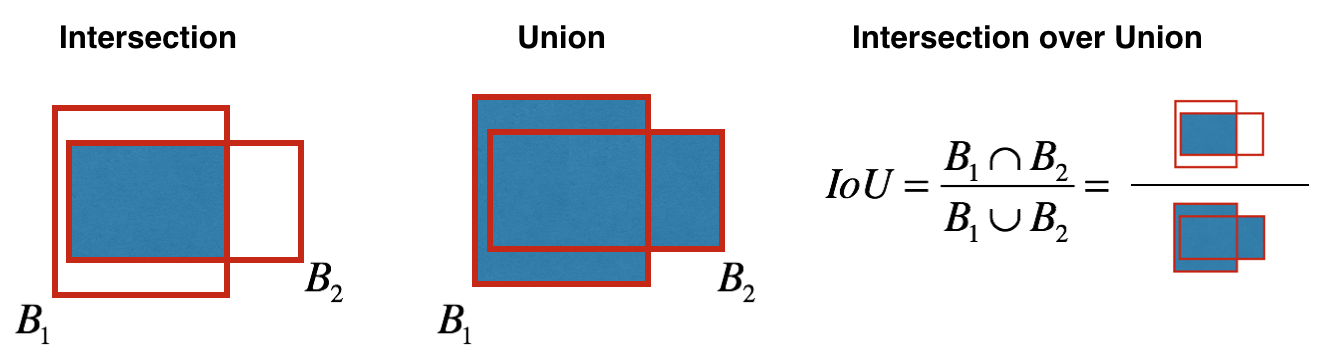

### Implement IOU
- We uses the convention that (0, 0) is the top-left corner of an image, (1, 0) is the upper right corner, and (1, 1) is the lower-right corner. In other words, the (0, 0) origin starts at the top left corner of the image. As x increases, we move to the right, As y increases, we move down.
- A box is defined using its 2 corners : upper left (x_1, y_1) and lower right (x_2, y_2), instead of using the midpoint, height and width. This makes it a bit easier to calculate the intersection.
- To calculate the area od the rectange, multiply its height (y2-y1) by its width (x2-x1). 

In [6]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = max(0, xi2-xi1)
    inter_height = max(0, yi2-yi1)
    inter_area = inter_width * inter_height
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_y2-box1_y1) * (box1_x2-box1_x1)
    box2_area =  (box2_y2-box2_y1) * (box2_x2-box2_x1)
    union_area =  box2_area + box1_area - inter_area
    
    # compute the IoU
    iou = inter_area/union_area
    
    return iou

In [7]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)
print("iou for intersecting boxes = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0


## 2.4 YOLO non-max supression
- We are now ready to implement non-max supression. The key steps are :
    1. Select the box that has the highest score.
    2. Compute the overlap of the box with all other boxes, and remove boxes that overlap significantly (iou >= iou_threshold)
    3. Go back to step1 and iterate until there are no more boxes with a lower score than the currently selected box.
- This will remove all boxes that have a large overlap with the selected boxes. Only the best boxes remain.

In [8]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [9]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

scores[2] = 8.147684
boxes[2] = [ 6.0797963   3.743308    1.3914018  -0.34089637]
classes[2] = 1.7079165
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


## 2.5 Wrapping up the Filtering
- It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions we've implemented.

In [10]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [18]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

In [19]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [20]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


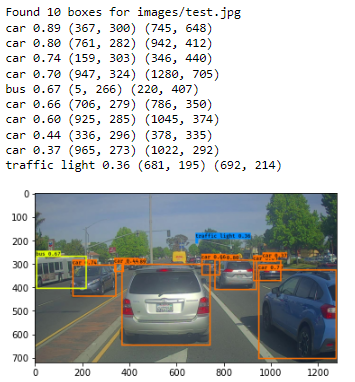

# Summary
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19, 19, 5, 85) dimensional output.
- After flattening the last 2 dimensions, the output is a volume of shape (19, 19, 425)
    - Each cell in a 19x19 grid over the output in a volume of shape (19, 19, 425)
    - 425 = 5x85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, 
    - 85 = 5 + 80 where 5 is because (p_c, b_x, b_y, b_h, b_w) has 5 numbers, and 80 is the number of classes we'd like to detect.
- We then select only few boxes based on :
    - Score-threshold : throw awy boxes that have detected a class with a score less than the threshold
    - Non-max supression : Compute the intersection over union and avoid selecting overlapping boxes
- This gives us YOLO's final output
- YOLO is a state-of-the-art object detection model that is fast and accurate.
- It runs an input image through a CNN, which outputs a 19x19x5x85 dimensional volume.
- The encoding can ve seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- We filter through all the boxes using non-max supresson. Specifically :
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trival and requires a large dataset as well as lot of computation.